# Ensemble of models with NO PET as input ...

In [29]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")

from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from scripts.read_nh_results import (
    read_multi_experiment_results,
    calculate_member_errors,
    calculate_all_error_metrics
)

In [3]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/ensemble_NO_EVAP"

In [33]:
cfg = Config([f for f in run_dir.iterdir() if f.is_dir()][0] / "config.yml")
assert cfg.dynamic_inputs == ['precipitation', 'temperature']

In [4]:
if not (run_dir / "member_ds.nc").exists():
    member_ds = read_multi_experiment_results(ensemble_dir=run_dir, ensemble_members=True)
    member_ds.to_netcdf(run_dir / "member_ds.nc")

else:
    member_ds = xr.open_dataset(run_dir / "member_ds.nc")


In [5]:
if not (run_dir / "member_errors.nc").exists():
    member_errors = calculate_member_errors(
        member_ds, 
        basin_coord="station_id", 
        time_coord="time", 
        obs_var="obs",
        sim_var="sim",
        metrics=["NSE", "KGE", "Pearson-r", "FHV", "FMS", "FLV",]
    )
    member_errors.to_netcdf(run_dir / "member_errors.nc")
else:
    member_errors = xr.open_dataset(run_dir / "member_errors.nc")

In [18]:
member_ds

<xarray.Dataset>
Dimensions:     (member: 8, station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * member      (member) object 'ensemble6' 'ensemble7' ... 'ensemble1'
Data variables:
    obs         (member, station_id, time) float64 2.37 2.49 2.42 ... 0.73 0.79
    sim         (member, station_id, time) float64 1.918 2.288 ... 0.856 0.793

In [20]:
min_ = member_ds.min(dim=["member"])
max_ = member_ds.max(dim=["member"])
median_ = member_ds.median(dim=["member"])
mean_ = member_ds.mean(dim=["member"])
std_ = member_ds.std(dim=["member"])

### calculate median error

In [21]:
from scripts.read_nh_results import calculate_all_error_metrics

if not (run_dir / "med_errors.nc").exists():
    med_errors = calculate_all_error_metrics(preds=median_, basin_coord="station_id", time_coord="time", obs_var="obs", sim_var="sim")
    med_errors.to_netcdf(run_dir / "med_errors.nc")
else:
    med_errors = xr.open_dataset(run_dir / "med_errors.nc")
    


if not (run_dir / "mean_errors.nc").exists():
    mean_errors = calculate_all_error_metrics(preds=mean_, basin_coord="station_id", time_coord="time", obs_var="obs", sim_var="sim")
    mean_errors.to_netcdf(run_dir / "mean_errors.nc")
else:
    mean_errors = xr.open_dataset(run_dir / "mean_errors.nc")
    
med_errors
med_errors

Calculating Errors: 100%|██████████| 669/669 [01:59<00:00,  5.59it/s, 97002]


<xarray.Dataset>
Dimensions:      (station_id: 667)
Coordinates:
  * station_id   (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    Alpha-NSE    (station_id) float64 ...
    Beta-NSE     (station_id) float64 ...
    FHV          (station_id) float64 ...
    FLV          (station_id) float64 ...
    FMS          (station_id) float64 ...
    KGE          (station_id) float64 ...
    MSE          (station_id) float64 ...
    NSE          (station_id) float64 ...
    Peak-Timing  (station_id) float64 ...
    Pearson-r    (station_id) float64 ...
    RMSE         (station_id) float64 ...

# Check the hydrographs

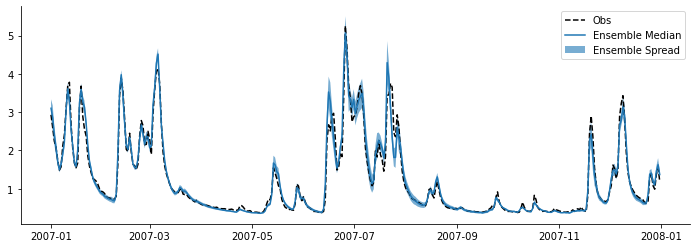

In [17]:
time = "2007"
choices = np.random.choice(member_ds.station_id.values, 3)

px = choices[0]

f, ax = plt.subplots(figsize=(12, 4))
md = median_.sel(station_id=px, time=time).to_dataframe()
# mn = min_.sel(station_id=px, time=time).to_dataframe()
# mx = max_.sel(station_id=px, time=time).to_dataframe()
mn = median_.sel(station_id=px, time=time).to_dataframe() - std_.sel(station_id=px, time=time).to_dataframe()
mx = median_.sel(station_id=px, time=time).to_dataframe() + std_.sel(station_id=px, time=time).to_dataframe()

ax.plot(md.index, md["obs"], color="k", ls="--", label="Obs")
ax.plot(md.index, md["sim"], color="C0", label="Ensemble Median")
ax.fill_between(md.index, mn["sim"], mx["sim"], label="Ensemble Spread", alpha=0.6)
ax.legend()
sns.despine()

# How does it compare to the w/evap model?

In [51]:
w_evap_run_dir = run_dir.parent / "ensemble_lstm_TEMP"

ref_preds = xr.open_dataset(w_evap_run_dir / "ensemble_all.nc")
if "ref_errors" not in globals().keys():
    ref_errors = calculate_all_error_metrics((ref_preds.sel(member="mean")), basin_coord="station_id", time_coord="time", sim_var="sim", obs_var="obs")

Calculating Errors: 100%|██████████| 669/669 [02:05<00:00,  5.35it/s, 97002]


<xarray.Dataset>
Dimensions:      (station_id: 667)
Coordinates:
  * station_id   (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    Alpha-NSE    (station_id) float64 0.9487 0.9139 0.9957 ... 0.8474 0.865
    Beta-NSE     (station_id) float64 -0.1054 -0.1264 ... -0.005181 -0.04751
    FHV          (station_id) float64 -6.889 -6.952 5.952 ... -14.34 -14.57
    FLV          (station_id) float64 4.237 31.93 70.29 ... 49.43 -14.23 57.27
    FMS          (station_id) float64 23.57 5.715 -17.86 ... -5.765 -19.92 10.9
    KGE          (station_id) float64 0.874 0.862 0.9274 ... 0.8277 0.8399
    MSE          (station_id) float64 0.2358 0.1281 0.5838 ... 12.29 0.8345
    NSE          (station_id) float64 0.8955 0.916 0.8581 ... 0.8417 0.868
    Peak-Timing  (station_id) float64 0.4167 0.24 0.3704 ... 0.2 0.03571 0.16
    Pearson-r    (station_id) float64 0.9521 0.9668 0.9288 ... 0.9203 0.9355
    RMSE         (station_id) float64 0.4856 0.3579 0.764 ... 1.019 3.506 0.9135

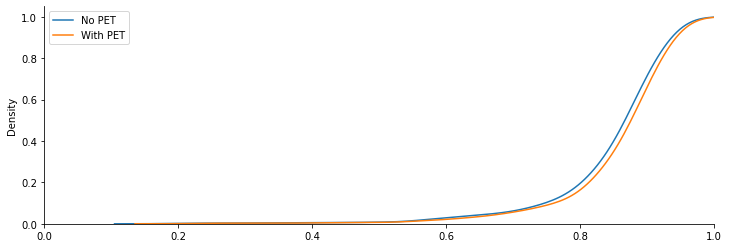

In [55]:
from scripts.cell_state.analysis import finite_flat

x = finite_flat(mean_errors["NSE"].values)
f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(x, cumulative=True, ax=ax, label="No PET")
sns.kdeplot(finite_flat(ref_errors["NSE"].values), cumulative=True, ax=ax, label="With PET")
ax.set_xlim(0, 1)
ax.legend()
sns.despine()
# n, bins, patches = ax.hist(x, bins=100, density=True, histtype='stepfilled', cumulative=True, label='Empirical', alpha=0.6)

In [10]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points

In [11]:
points = load_latlon_points(data_dir=Path("/home/tommy/spatio_temporal/data"))

In [12]:
gdf = gpd.GeoDataFrame(med_errors["NSE"].to_dataframe().join(points))

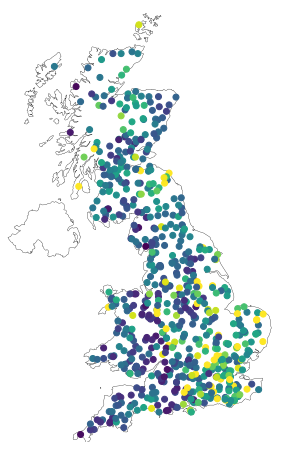

In [13]:
ax = initialise_gb_spatial_plot()
gdf.plot("NSE", ax=ax, vmin=0.7, cmap="viridis_r");

# where is the uncertainty highest?